In [2]:
import sys
sys.path.remove('/opt/ros/kinetic/lib/python2.7/dist-packages')

In [3]:
import cv2
img=cv2.imread('levine.pgm')
# print(img)

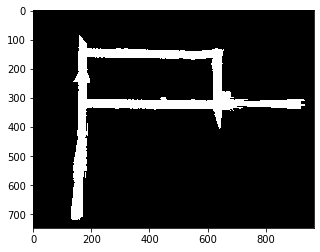

In [4]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
plt.imshow(img,cmap='gray')

0.0 43.071067690849304


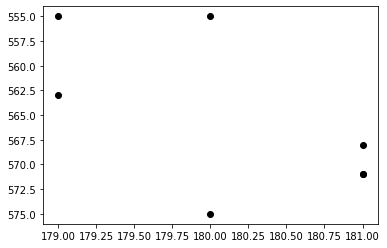

In [5]:
import numpy as np
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import scipy.interpolate
from matplotlib import pyplot as plt
%matplotlib inline

# process image, get in and out contours
im = cv.imread('levine.pgm')
imgray = cv.cvtColor(im, cv.COLOR_BGR2GRAY)
ret, thresh = cv.threshold(imgray, 127, 255, 0)
contours, hierarchy = cv.findContours(thresh, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
cv.drawContours(im, contours, -1, (0,0,255), 3)

arc_out=cv.arcLength(contours[0],True)
arc_in=cv.arcLength(contours[1],True)
print(arc_out,arc_in)

out_cnt=np.asarray(contours[0])
out_cnt=np.reshape(out_cnt,(-1,2))
out_cnt=np.vstack((out_cnt,out_cnt[0,:]))
# compute convex hull of in contour
in_cnt=cv.convexHull(contours[1])
in_cnt=np.asarray(in_cnt)

# nonconvexhull
# in_cnt=np.asarray(contours[1])


in_cnt=np.reshape(in_cnt,(-1,2))
in_cnt=np.vstack((in_cnt,in_cnt[0,:]))


x,y=in_cnt[:,0],in_cnt[:,1]
plt.plot(x,y, 'ok',label='poly')
# plt.axes.Axes.invert_yaxis
ax = plt.gca()
ax.invert_yaxis()
plt.show()

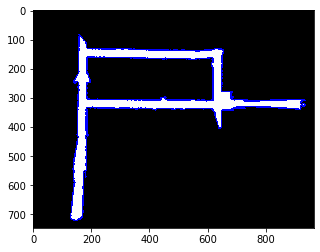

In [6]:
plt.imshow(im,cmap='gray')

In [7]:
# import waypoints from csv
from numpy import genfromtxt
my_data = genfromtxt('levine_waypoints.csv', delimiter=',')
x,y=my_data[:,0],my_data[:,1]
old_points=my_data[:,0:2]

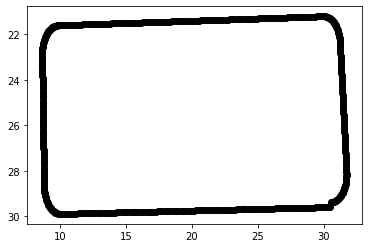

In [8]:
plt.plot(old_points[:,0],old_points[:,1],'ok', label='original points');
ax = plt.gca()
ax.invert_yaxis()

[  0  10  20  30  40  50  60  70  80  90 100 110 120 130 140 150 160 170
 180 190 200 210 220 230 240 250 260 270 280 290 300 310 320 330 340 350
 360 370 380 390 400 410 420 430 440 450 460 470 480 490 500 510]


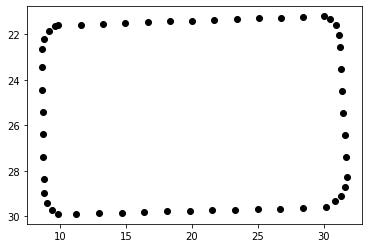

In [9]:
# subsample waypoints
stride=10
ids=np.arange(0,len(old_points),stride)
print(ids)
old_points=old_points[ids]
plt.plot(old_points[:,0],old_points[:,1],'ok', label='original points');
ax = plt.gca()
ax.invert_yaxis()


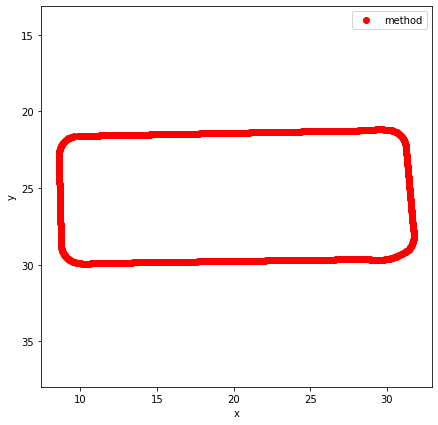

In [10]:
import numpy as np
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
from scipy.interpolate import UnivariateSpline
import pdb
# interpolate
# fit spline
def interp_line(points,n):
    # Linear length along the line:
    distance = np.cumsum( np.sqrt(np.sum( np.diff(points, axis=0)**2, axis=1 )) )
    distance = np.insert(distance, 0, 0)/distance[-1]
#     print('distance',distance)
    alpha = np.linspace(0, 1, n)
#     alpha=np.arange(0,n,1)
    interpolated_points = {}
    method='cubic'
#     method='quadratic'
#     method='slinear'
    interpolator =  interp1d(distance, points, kind=method, axis=0)
    interpolated_points['method'] = interpolator(alpha)
    plt.figure(figsize=(7,7))
    for method_name, curve in interpolated_points.items():
        plt.plot(*curve.T, 'or', label=method_name);
#     print(curve.shape)
    plt.axis('equal'); plt.legend(); plt.xlabel('x'); plt.ylabel('y');
    ax = plt.gca()
    ax.invert_yaxis()
    return curve
    

def fit_spline(points,n):

    distance = np.cumsum( np.sqrt(np.sum( np.diff(points, axis=0)**2, axis=1 )) )
    distance = np.insert(distance, 0, 0)/distance[-1]
    splines = [UnivariateSpline(distance, coords, k=3, s=.2) for coords in points.T]
    alpha = np.linspace(0, 1, n)
    points_fitted = np.vstack( spl(alpha) for spl in splines ).T
    # Graph:
    plt.plot(*points.T, 'ok', label='original points');
    plt.plot(*points_fitted.T, '-r', label='fitted spline k=3, s=.2');
    plt.axis('equal'); plt.legend(); plt.xlabel('x'); plt.ylabel('y');
    ax = plt.gca()
    ax.invert_yaxis()
    return points_fitted

n=1000

new_points=interp_line(old_points,n)
# new_points=fit_spline(old_points,n)

# print(new_points.shape)

In [11]:
from scipy.interpolate import UnivariateSpline
import numpy as np

def curvature_splines(x, y=None, error=0.1):
    """Calculate the signed curvature of a 2D curve at each point
    using interpolating splines.
    Parameters
    ----------
    x,y: numpy.array(dtype=float) shape (n_points, )
         or
         y=None and
         x is a numpy.array(dtype=complex) shape (n_points, )
         In the second case the curve is represented as a np.array
         of complex numbers.
    error : float
        The admisible error when interpolating the splines
    Returns
    -------
    curvature: numpy.array shape (n_points, )
    Note: This is 2-3x slower (1.8 ms for 2000 points) than `curvature_gradient`
    but more accurate, especially at the borders.
    """

    # handle list of complex case
    if y is None:
        x, y = x.real, x.imag

    t = np.arange(x.shape[0])
    std = error * np.ones_like(x)

    fx = UnivariateSpline(t, x, k=4, w=1 / np.sqrt(std))
    fy = UnivariateSpline(t, y, k=4, w=1 / np.sqrt(std))

    xˈ = fx.derivative(1)(t)
    xˈˈ = fx.derivative(2)(t)
    yˈ = fy.derivative(1)(t)
    yˈˈ = fy.derivative(2)(t)
    curvature = (xˈ* yˈˈ - yˈ* xˈˈ) / np.power(xˈ** 2 + yˈ** 2, 1.5)
    return curvature

curv = curvature_splines(new_points[:,0], new_points[:,1], error=1e-10)
curv[curv<0]=0
# test = curvature_splines(new_points[:,0], new_points[:,1], error=0.1)

In [12]:
# t=range(0,len(curv))
# # plt.plot(t,curv)
# fig, (ax1, ax2) = plt.subplots(2,1)
# fig.suptitle('Vertically stacked subplots')
# ax1.plot(t, curv,'o')
# ax1.set_title('curvature')
# ax2.plot(t,new_points[:,0],'o')
# ax2.set_title('x')
# # plt.plot(t,new_points[:,0])


(1000,)


Text(0.5, 1.0, 'velocity')

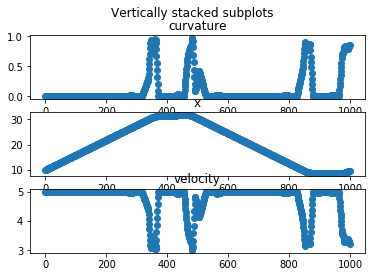

In [13]:
# calculate velovity profile
max_vel,min_vel=5,3

velocity=np.empty_like(curv)
nonzero_ids=curv>0
zero_ids=curv==0
max_curv = np.max(curv)
delta=max_curv-curv[nonzero_ids]
increment=(max_vel-min_vel)/max_curv
velocity[zero_ids]=max_vel
velocity[nonzero_ids]=3+delta*increment
print(velocity.shape)


t=range(0,len(curv))
# plt.plot(t,curv)
fig, (ax1, ax2,ax3) = plt.subplots(3,1)
fig.suptitle('Vertically stacked subplots')
ax1.plot(t, curv,'o')
ax1.set_title('curvature')
ax2.plot(t,new_points[:,0],'o')
ax2.set_title('x')
ax3.plot(t,velocity,'o')
ax3.set_title('velocity')
# plt.plot(t,new_points[:,0])



In [23]:
data=np.hstack((new_points,np.reshape(curv,(-1,1)),np.reshape(velocity,(-1,1))))
np.savetxt('levine_processed.csv',data,delimiter=',')

In [18]:
# np.savetxt('levine_processed.csv',(np.hstack((new_points,np.reshape(curv,(-1,1))))),delimiter=',')

In [21]:
type(data)

numpy.ndarray